# Needed libraries

In [35]:
from numpy.random import normal
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
colorsss = ['royalblue', 'gold' , 'green', 'purple',  'cyan']
import sys
from tqdm import tqdm

from dadapy import Data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from scipy import ndimage
from scipy.stats import binned_statistic_2d
import pickle

import pandas as pd
import seaborn as sns

from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astroquery.vizier import Vizier
import astropy.units as u
from scipy.stats import ks_2samp,cramervonmises_2samp
from time import time
from matplotlib.lines import Line2D
from collections import Counter


In [2]:
module_path = 'demeter/'
sys.path.append(module_path)
import demeter 

/home/mdelosrios/miniconda3/envs/dwarf/lib/python3.13/site-packages/pytorch_wavelets/dtcwt/coeffs.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


In [3]:
# Directory setup for custom modules
module_path = 'EagleEye/eagleeye'
sys.path.append(module_path)
import EagleEye
from EagleEye import S_SB_estimate_X_overdensities
from EagleEye import S_SB_estimate_Y_overdensities
from utils_EE import compute_the_null, partitioning_function

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [5]:
from IPython.core.magic import register_line_magic
import re
import matplotlib.pyplot as plt
import os

# Estado global
save_next_plot = {"enabled": False, "path": "./"}

@register_line_magic
def plot(line):
    """
    Uso:
    %plot save_plot=True path="./mis_plots/"
    %plot save_plot=False
    """
    global save_next_plot
    
    # Activar/desactivar guardado
    match = re.search(r"save_plot\s*=\s*(True|False)", line, re.IGNORECASE)
    if match:
        save_next_plot["enabled"] = match.group(1).lower() == "true"
    
    # Buscar path si está definido
    match_path = re.search(r'path\s*=\s*["\']?([^\s"\']+)["\']?', line)
    if match_path:
        save_next_plot["path"] = match_path.group(1)
        # Crear la carpeta si no existe
        os.makedirs(save_next_plot["path"], exist_ok=True)
    
    estado = "activado" if save_next_plot["enabled"] else "desactivado"
    print(f"Guardado de plots {estado}. Carpeta: {save_next_plot['path']}")

def auto_save_plot(filename="plot.png"):
    """
    Guarda el plot en la carpeta definida si save_plot está activado.
    """
    full_path = os.path.join(save_next_plot["path"], filename)
    
    if save_next_plot["enabled"]:
        plt.savefig(full_path)
        print(f"✅ Plot guardado en {full_path}")
    else:
        print("ℹ️ Guardado desactivado, no se guardó el plot.")
    
    plt.show()


In [6]:
%plot save_plot=True path='../graphs/'

Guardado de plots activado. Carpeta: ../graphs/


# Custom Functios

In [7]:
def run_demeter(full_field_gno, random_field_gno):
    grid_size = 96
    edge_size = 6
    front = int(edge_size)
    back  = int(grid_size-edge_size)

    random_image, edges = demeter.make_field_image(random_field_gno, gnomonic_width, pmfield_size, grid_size)
    field_image, edges = demeter.make_field_image(full_field_gno, gnomonic_width, pmfield_size, grid_size)

    smooth_field = scipy.ndimage.gaussian_filter(field_image,3.0)
    
    wv = demeter.WaveNet(grid_size, grid_size, J=4, wavelets = ['bior5.5']).to(device)
    out = wv(torch.Tensor(field_image).to(device)).to('cpu').numpy()
    rand_out = wv(torch.Tensor(random_image).to(device)).to('cpu').numpy()

    #apply smoothing 
    out = scipy.ndimage.gaussian_filter(out,3.0)
    rand_out = scipy.ndimage.gaussian_filter(rand_out,3.0)

    #remove outer edges of image 
    out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
    out1[front:back,front:back,front:back,front:back] = 1
    out1 = out*out1

    #standardize the real output 
    out = (out-np.mean(rand_out))/np.std(rand_out)

    #apply threshold 
    edge_size = 6
    front = int(edge_size)
    back = int(grid_size-edge_size)
    nstars = len(data)
    
    #apply significance correction 
    out = out / (-0.6*np.log10(nstars)+4.)
    
    #applying thresholding 
    mask = out < 5.0 
    out[mask] = 0
    
    #remove outer edges of image
    out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
    out1[front:back,front:back,front:back,front:back] = 1
    out1 = out*out1

    #find remaining hotspots 
    blobs, significance = demeter.find_blobs(out1, threshold=9)

    return blobs, significance

In [8]:
color_cl = 'red'
color_full = 'darkcyan'
color_dw = 'coral'
color_ref = 'black'

labels = ['$l$ [°]','$b$ [°]','$\mu_{l}$ [mas/yr]','$\mu_{b}$ [mas/yr]']



def plotDwarf(ax, dw_data, full = None, ref = None, indices = None, nbins = 20):
    bins = [np.linspace(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2, nbins),
            np.linspace(np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2, nbins),
            np.linspace(np.mean(dw_data[:,2]) - 3, np.mean(dw_data[:,2]) + 3, nbins),
            np.linspace(np.mean(dw_data[:,3]) - 3, np.mean(dw_data[:,3]) + 3, nbins)]

    lims = [(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2),
            (np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2),
            (np.mean(dw_data[:,2]) - 5, np.mean(dw_data[:,2]) + 5),
            (np.mean(dw_data[:,3]) - 5, np.mean(dw_data[:,3]) + 5)]

    if indices is not None: 
        cluster = full[indices,:] 
    else: 
        cluster = None
    
    for i in range(4):
        for j in range(4):
            if i < j: ax[i,j].set_axis_off()
            if i > j:
                #ax[i,j].set_xlim(lims[j])
                ax[i,j].set_ylim(lims[i])
                if cluster is not None: ax[i,j].scatter(cluster[:,j], cluster[:,i], edgecolor = color_cl, label = 'Cl', 
                                                        marker = 'o', s = 20, facecolor = 'none')
                if ref is not None: ax[i,j].scatter(ref[:,j], ref[:,i], color = color_ref, label = 'Ref', marker = '.', s = 5)
                if full is not None: ax[i,j].scatter(full[:,j], full[:,i], color = color_full, label = 'Bkg', marker = '.', s = 5)
                ax[i,j].scatter(dw_data[:,j], dw_data[:,i], color = color_dw, label = 'Dwarf', marker = '+')
            if i == j:
                if ref is not None: ax[i,j].hist(ref[:,i], histtype = 'step', density = True, bins = bins[i], color = color_ref)
                if full is not None: ax[i,j].hist(full[:,i], histtype = 'step', density = True, bins = bins[i], color = color_full)
                ax[i,j].hist(dw_data[:,i], histtype = 'step', density = True, bins = bins[i], color = color_dw)
                if cluster is not None: ax[i,j].hist(cluster[:,i], histtype = 'step', density = True, bins = bins[i], color = color_cl)
            if i == 3: 
                ax[i,j].set_xlabel(labels[j])
            #else:
             #   ax[i,j].set_xticks([])
            if j == 0: 
                ax[i,j].set_ylabel(labels[i])
            else: 
                ax[i,j].set_yticks([])
        
    ax[0,0].set_xlim(lims[0])
    ax[3,1].set_xlim(lims[1])
    ax[3,2].set_xlim(lims[2])
    ax[3,3].set_xlim(lims[3])
    
    ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (2,2))
    return ax

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_266474/1905663237.py:6: SyntaxWarning: invalid escape sequence '\m'
  labels = ['$l$ [°]','$b$ [°]','$\mu_{l}$ [mas/yr]','$\mu_{b}$ [mas/yr]']
/tmp/ipykernel_266474/1905663237.py:6: SyntaxWarning: invalid escape sequence '\m'
  labels = ['$l$ [°]','$b$ [°]','$\mu_{l}$ [mas/yr]','$\mu_{b}$ [mas/yr]']


In [9]:
def GetBkg(glon_center, glat_center, row_limit = None, size = 2, 
            delta_long = 5, delta_lat = 0, center = True):
    
    gcenter    = SkyCoord(frame="galactic", l = glon_center, b = glat_center, unit=(u.deg, u.deg))
    ra_center  = gcenter.transform_to('icrs').ra.value
    dec_center = gcenter.transform_to('icrs').dec.value
    
    v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
               column_filters={"Host":"1", 'Gmag':'<20', 'r':'>7700','logg':'>3.3'}, row_limit = -1)
    
    bkg = v.query_region(SkyCoord(ra = ra_center, dec=dec_center, unit=(u.deg, u.deg),frame='icrs'),
                            width= str(size) + "d",
                            catalog=["VI/137/gum_mw"])
    
    equatorial_coords = SkyCoord( ra  = bkg[0]['RAICRS'], 
                                  dec = bkg[0]['DEICRS'], 
                                  pm_ra_cosdec =  bkg[0]['pmRA'], 
                                  pm_dec = bkg[0]['pmDE'], 
                                  frame = 'icrs')
    
    # Transform to Galactic coordinates
    galactic_coords = equatorial_coords.transform_to('galactic')
    glon_full = galactic_coords.l.value
    glat_full = galactic_coords.b.value
    
    # Access proper motion in Galactic coordinates
    pmlon_full = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
    pmlat_full = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
    
    full = np.vstack((glon_full, glat_full, pmlon_full, pmlat_full)).T
    
    if row_limit is not None:
        np.random.shuffle(full)
        full = full[:row_limit]

    return full

In [10]:
def GetRef(glon_center, glat_center, row_limit = None, size = 2, 
            reference = 'sim', ref_par = 2, delta_long = 5, delta_lat = 0, center = True):
    
    gcenter    = SkyCoord(frame="galactic", l = glon_center, b = glat_center, unit=(u.deg, u.deg))
    ra_center  = gcenter.transform_to('icrs').ra.value
    dec_center = gcenter.transform_to('icrs').dec.value
    
    v = Vizier(columns=['RAICRS','DEICRS','pmRA','pmDE'],
               column_filters={"Host":"1", 'Gmag':'<20', 'r':'>7700','logg':'>3.3'}, row_limit = -1)
    
    if reference == 'sim':
        glon_ref = glon_center + delta_long
        glat_ref = glat_center + delta_lat
        gref = SkyCoord(frame="galactic", l = glon_ref, b = glat_ref, unit=(u.deg, u.deg))
        
        ra_ref = gref.transform_to('icrs').ra.value
        dec_ref = gref.transform_to('icrs').dec.value
        
        ref = v.query_region(SkyCoord(ra = ra_ref, dec=dec_ref, unit=(u.deg, u.deg),frame='icrs'),
                                width= str(size) + "d",
                                catalog=["VI/137/gum_mw"])
        
        equatorial_coords = SkyCoord( ra  = ref[0]['RAICRS'], 
                                      dec = ref[0]['DEICRS'], 
                                      pm_ra_cosdec =  ref[0]['pmRA'], 
                                      pm_dec = ref[0]['pmDE'], 
                                      frame = 'icrs')
        
        # Transform to Galactic coordinates
        galactic_coords = equatorial_coords.transform_to('galactic')
        if center:
            glon_ref = galactic_coords.l.value - glon_ref + glon_center # To center around the same longitud
            glat_ref = galactic_coords.b.value - glat_ref + glat_center # To center around the same latitud
        else:
            glon_ref = galactic_coords.l.value 
            glat_ref = galactic_coords.b.value
        
        # Access proper motion in Galactic coordinates
        pmlon_ref = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
        pmlat_ref = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)
        
        ref = np.vstack((glon_ref, glat_ref, pmlon_ref, pmlat_ref)).T

        # If they are center we can remove the ones that are outside the patch
        if center:
            ind = np.where( (ref[:,0] >= np.min(full[:,0])) &
                            (ref[:,0] <= np.max(full[:,0])) &
                            (ref[:,1] >= np.min(full[:,1])) &
                            (ref[:,1] <= np.max(full[:,1])) &
                            (ref[:,2] >= np.min(full[:,2])) &
                            (ref[:,2] <= np.max(full[:,2])) &
                            (ref[:,3] >= np.min(full[:,3])) &
                            (ref[:,3] <= np.max(full[:,3])) 
                          )[0]
            ref = ref[ind]
        
    if reference == 'random':
        glon_ref = glon_center
        glat_ref = glat_center
        gref = SkyCoord(frame="galactic", l = glon_ref, b = glat_ref, unit=(u.deg, u.deg))
        
        ra_ref = gref.transform_to('icrs').ra.value
        dec_ref = gref.transform_to('icrs').dec.value

        # Query a zone 3 times bigger than the bkg
        ref = v.query_region(SkyCoord(ra = ra_ref, dec=dec_ref, unit=(u.deg, u.deg),frame='icrs'),
                                width= str(3*size) + "d",
                                catalog=["VI/137/gum_mw"])
        
        equatorial_coords = SkyCoord( ra  = ref[0]['RAICRS'], 
                                      dec = ref[0]['DEICRS'], 
                                      pm_ra_cosdec =  ref[0]['pmRA'], 
                                      pm_dec = ref[0]['pmDE'], 
                                      frame = 'icrs')
        
        # Transform to Galactic coordinates
        galactic_coords = equatorial_coords.transform_to('galactic')
        glon_ref = galactic_coords.l.value - glon_ref + glon_center # To center around the same longitud
        glat_ref = galactic_coords.b.value
        
        # Access proper motion in Galactic coordinates
        pmlon_ref = galactic_coords.pm_l_cosb.to(u.mas/u.yr).value  # Proper motion in Galactic longitude (l)
        pmlat_ref = galactic_coords.pm_b.to(u.mas/u.yr).value       # Proper motion in Galactic latitude (b)

        # Cut the bkg square where we will put the dwarf
        ref = np.vstack((glon_ref, glat_ref, pmlon_ref, pmlat_ref)).T
        ind = np.where( (ref[:,0] >= np.min(full[:,0])) &
                        (ref[:,0] <= np.max(full[:,0])) &
                        (ref[:,1] >= np.min(full[:,1])) &
                        (ref[:,1] <= np.max(full[:,1])) 
                      )[0]
        ref = np.delete(ref, ind, axis = 0)

        # pick len(full) random galaxies from the reference
        ind = np.random.choice(np.arange(len(ref)), size = len(full), replace = False)
        ref = ref[ind]
        ref[:,0] = np.random.uniform(np.min(full[:,0]), np.max(full[:,0]), size = len(ref))
        ref[:,1] = np.random.uniform(np.min(full[:,1]), np.max(full[:,1]), size = len(ref))
        
    if reference == 'noisy':
        ref = np.copy(full)
        ref[:,0] = ref[:,0] + np.random.normal(0, np.std(dw_data[:,0]) / ref_par, len(ref[:,0]))
        ref[:,1] = ref[:,1] + np.random.normal(0, np.std(dw_data[:,1]) / ref_par, len(ref[:,1]))
        ref[:,2] = ref[:,2] + np.random.normal(0, np.std(dw_data[:,2]) / ref_par, len(ref[:,2]))
        ref[:,3] = ref[:,3] + np.random.normal(0, np.std(dw_data[:,3]) / ref_par, len(ref[:,3]))

    if reference == 'shuffle':
        ref = np.copy(full)
        rand_ind = np.random.choice(np.arange(len(ref)), size = len(ref), replace = False)
        ref[:,2] = ref[rand_ind,2]
        ref[:,3] = ref[rand_ind,3]
        
    if row_limit is not None:
        
        np.random.shuffle(ref)
        ref = ref[:row_limit]


    return ref

# Let's load the data

In [11]:
# Let's load the true data for the galaxies
ifile = 96
data = np.loadtxt('../data/mocks/library.survey.UFGX_LIB' + str(ifile) + '.dat')

# the (true) physical parameters of each of the simulated UFs
#ID    - UFGX ID
#Lv    - Total integrated luminosity of UFGX
#M/L   - Mass to light ratio, in solar units
#sigma - Velocity dispersion of Plummer model
#rh    - Half-light radius of Plummer model
#Rhel  - Heliocentric distance of center of mass
#l     - Galactic longitude of center of mass
#b     - Galactic latitude
#Vgal  - Velocity modulus of center of mass. Reference frame at rest, in GC
#Phi   - Azimuthal angle of center of mass velocity vector
#Theta - Latitude angle of center of mass velocity vector
#stMass - Total stellar mass
#Nobs  - Number of observable stars in UFGX
#Theta  - Apparent size in l-b plane 
#dmu    - Apparent size in mul-mub plane
#mucm   - Apparent center-of-mass proper motion
#Note: Lv recomputed with new function 02/2015
# unit:         Lsun           M/Lsun      km/s       kpc       kpc   deg   deg   km/s deg   deg   Msolar             deg   mas/yr   mas/yr   mas/yr   mas/yr
#    ID           Lv              M/L    sigmav        rh      dist     l     b   Vgal phiv thetav   stMass   Nobs    theta      dmu     mucm    mulcm    mubcm


In [12]:
ind_good = np.where((data[:,12] / data[:,13] > 2e4) & (data[:,12] / data[:,14] > 2e3))[0][4]
ind_bad = np.where((data[:,12] / data[:,13] < 1e2) & (data[:,12] / data[:,14] < 2e1))[0][4]
ind_mid = np.where((data[:,12] / data[:,13] > 5e2) & 
                   (data[:,12] / data[:,13] < 9e2) &
                   (data[:,12] / data[:,14] > 7e2) &
                   (data[:,12] / data[:,14] < 9e2)
                  )[0][4]

✅ Plot guardado en ../graphs/pars.png


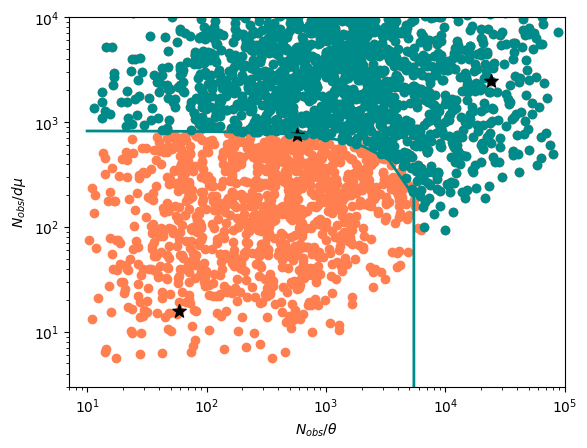

In [13]:
x0 = 200
y0 = 8e2
x1 = 7e3
y1 = 2e1
a = (y0-y1)/(x0-x1)
b = y0-x0*a

plt.scatter(data[:,12] / data[:,13], data[:,12] / data[:,14], color = 'coral')
ind = np.where((data[:,12] / data[:,14]) > (b+a*data[:,12] / data[:,13]))[0]
plt.scatter(data[ind,12] / data[ind,13], data[ind,12] / data[ind,14], c = 'darkcyan')
plt.plot(np.logspace(1,5,20), a*np.logspace(1,5,20) + b, c = 'darkcyan', lw = 2)

plt.scatter(data[ind_good,12] / data[ind_good,13], data[ind_good,12] / data[ind_good,14], marker = '*', color = 'black', s = 100)
plt.scatter(data[ind_bad,12] / data[ind_bad,13], data[ind_bad,12] / data[ind_bad,14], marker = '*', color = 'black', s = 100)
plt.scatter(data[ind_mid,12] / data[ind_mid,13], data[ind_mid,12] / data[ind_mid,14], marker = '*', color = 'black', s = 100)

plt.xscale('log')
plt.yscale('log')
plt.xlim(7,1e5)
plt.ylim(3,1e4)

plt.xlabel('$N_{obs} / \\theta$')
plt.ylabel('$N_{obs} / d\\mu$')
auto_save_plot('pars.png')

In [14]:
# Let's get the background
bkg_data = GetBkg(glon_center = 85, glat_center = 30, row_limit = None, size = 2)

In [15]:
print(np.min(bkg_data, axis = 0))
print(np.max(bkg_data, axis = 0))
print(len(bkg_data))

[83.77 28.93 -7.53 -5.49]
[86.21 31.06  7.21  8.1 ]
1497


In [16]:
#Let's pick a dwarf as example
obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(data[ind_good,0])) + '.dat')
print(f'The dwarf galaxy has {len(obs)} stars')

glon_dw  = (obs[:,2] * 180/np.pi - 90) + 85 # Just to center the dwarf galaxy
glat_dw  = (obs[:,3] * 180/np.pi - 30) + 30
pmlon_dw = obs[:,5] / 1e3
pmlat_dw = obs[:,6] / 1e3
dw_data  = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T

# Remove dwarf stars outside patch
ind = np.where( (dw_data[:,0] >= np.min(bkg_data[:,0])) &
                (dw_data[:,0] <= np.max(bkg_data[:,0])) &
                (dw_data[:,1] >= np.min(bkg_data[:,1])) &
                (dw_data[:,1] <= np.max(bkg_data[:,1])) &
                (dw_data[:,2] >= np.min(bkg_data[:,2])) &
                (dw_data[:,2] <= np.max(bkg_data[:,2])) &
                (dw_data[:,3] >= np.min(bkg_data[:,3])) &
                (dw_data[:,3] <= np.max(bkg_data[:,3])) 
              )[0]
dw_data = dw_data[ind]

full = np.vstack((bkg_data, dw_data))

506


In [59]:
# Let's get the references
references = []

references.append( GetRef(glon_center = 85, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = 2, delta_lat = 2) )

references.append( GetRef(glon_center = 85, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = 2, delta_lat = 0) )

references.append( GetRef(glon_center = 85, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = 2, delta_lat = -2) )

references.append( GetRef(glon_center = 85, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = -2, delta_lat = 2) )

references.append( GetRef(glon_center = 85, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = -2, delta_lat = 0) )

references.append( GetRef(glon_center = 85, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = -2, delta_lat = -2) )

references.append( GetRef(glon_center = 85, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = 0, delta_lat = -2) )

references.append( GetRef(glon_center = 85, glat_center = 30, row_limit = None, size = 2, reference = 'sim', 
                             center = True, ref_par = 0, delta_long = 0, delta_lat = 2) )



In [60]:
# Let's add a dwarf in a random reference

l_dwarf_in_ref = []
size_l_dwarf_in_ref = []
b_dwarf_in_ref = []
size_b_dwarf_in_ref = []
mul_dwarf_in_ref = []
size_mul_dwarf_in_ref = []
mub_dwarf_in_ref = []
size_mub_dwarf_in_ref = []
n_dwarf_in_ref = []

np.random.seed(42)
for iref in [0,1,2,3]:
    igal = np.random.randint(len(data))
    obs = np.loadtxt('../data/mocks/obs.lib' + str(ifile) + '/UFGX_TEST' + str(ifile) + '_lib/obs_' + str(int(data[igal,0])) + '.dat')
    n_dwarf_in_ref.append(len(obs))
    print(len(obs))
    
    glon_dw  = (obs[:,2] * 180/np.pi - 90) + 85 + np.random.uniform(-1,1,1) # Just to center the dwarf galaxy and add a tiny displacement
    glat_dw  = (obs[:,3] * 180/np.pi - 30) + 30 - np.random.uniform(-1,1,1)
    pmlon_dw = obs[:,5] / 1e3
    pmlat_dw = obs[:,6] / 1e3
    aux_dw_data  = np.vstack((glon_dw, glat_dw, pmlon_dw, pmlat_dw)).T

    l_dwarf_in_ref.append(np.mean(glon_dw))
    size_l_dwarf_in_ref.append(np.std(glon_dw))
    b_dwarf_in_ref.append(np.mean(glat_dw))
    size_b_dwarf_in_ref.append(np.std(glat_dw))

    mul_dwarf_in_ref.append(np.mean(pmlon_dw))
    size_mul_dwarf_in_ref.append(np.std(pmlon_dw))
    mub_dwarf_in_ref.append(np.mean(pmlat_dw))
    size_mub_dwarf_in_ref.append(np.std(pmlat_dw))
    
    #iref = np.random.randint(len(references))
    print(iref, len(references[iref]))
    
    # Remove dwarf stars outside patch
    ind = np.where( (aux_dw_data[:,0] >= np.min(references[iref][:,0])) &
                    (aux_dw_data[:,0] <= np.max(references[iref][:,0])) &
                    (aux_dw_data[:,1] >= np.min(references[iref][:,1])) &
                    (aux_dw_data[:,1] <= np.max(references[iref][:,1])) &
                    (aux_dw_data[:,2] >= np.min(references[iref][:,2])) &
                    (aux_dw_data[:,2] <= np.max(references[iref][:,2])) &
                    (aux_dw_data[:,3] >= np.min(references[iref][:,3])) &
                    (aux_dw_data[:,3] <= np.max(references[iref][:,3])) 
                  )[0]
    aux_dw_data = aux_dw_data[ind]
    references[iref] = np.vstack((references[iref], aux_dw_data))
print(len(references[iref]))

18
0 1284
214
1 1410
739
2 1719
373
3 1311
1676


Text(0.5, 0, 'l [°]')

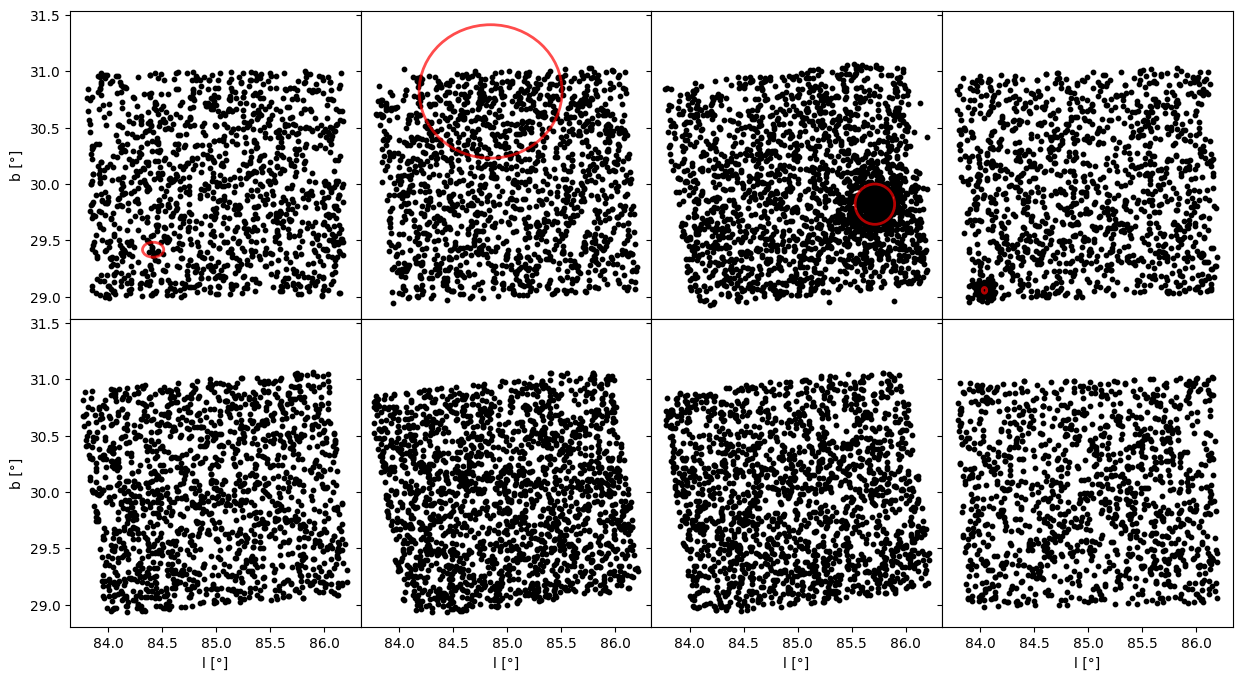

In [61]:
fig,ax = plt.subplots(2,4, gridspec_kw = {'wspace':0, 'hspace':0},
                     sharex = True, sharey = True,
                      figsize = (15,8))

for i in range(8):
    ref = references[i]
    ax[int(i/4),i%4].scatter(ref[:,0], ref[:,1], color = 'black', s = 10)
    ax[int(i/4),i%4].set_xlabel('')
    ax[int(i/4),i%4].set_ylabel('')

for i in range(4):
    elipse = patches.Ellipse((l_dwarf_in_ref[i], b_dwarf_in_ref[i]), 
                             size_l_dwarf_in_ref[i], size_b_dwarf_in_ref[i], 
                            edgecolor='red', facecolor='none', 
                            alpha=0.7, linewidth=2)
    
    # Añadir la elipse al eje
    ax[0,i].add_patch(elipse)
    
ax[0,0].set_ylabel('b [°]')
ax[1,0].set_ylabel('b [°]')
ax[1,0].set_xlabel('l [°]')
ax[1,1].set_xlabel('l [°]')
ax[1,2].set_xlabel('l [°]')
ax[1,3].set_xlabel('l [°]')

auto_save_plot('../graphs/References.pdf')

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_266474/2554466941.py:6: SyntaxWarning: invalid escape sequence '\m'
  labels = ['$l$ [°]','$b$ [°]','$\mu_{l}$ [mas/yr]','$\mu_{b}$ [mas/yr]']
/tmp/ipykernel_266474/2554466941.py:6: SyntaxWarning: invalid escape sequence '\m'
  labels = ['$l$ [°]','$b$ [°]','$\mu_{l}$ [mas/yr]','$\mu_{b}$ [mas/yr]']


✅ Plot guardado en ../graphs/8ref_example_gal_960138.pdf


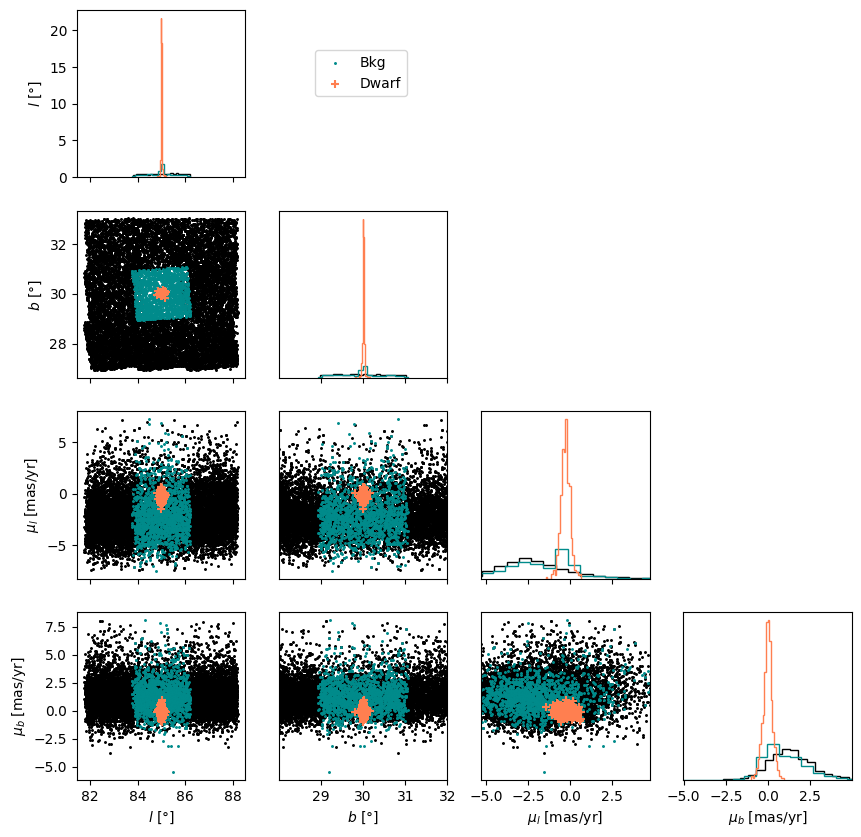

In [20]:
color_cl = 'red'
color_full = 'darkcyan'
color_dw = 'coral'
color_ref = 'black'

labels = ['$l$ [°]','$b$ [°]','$\mu_{l}$ [mas/yr]','$\mu_{b}$ [mas/yr]']

nbins = 20
bins = [np.linspace(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2, nbins),
        np.linspace(np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2, nbins),
        np.linspace(np.mean(dw_data[:,2]) - 3, np.mean(dw_data[:,2]) + 3, nbins),
        np.linspace(np.mean(dw_data[:,3]) - 3, np.mean(dw_data[:,3]) + 3, nbins)]

lims = [(np.mean(dw_data[:,0]) - 2, np.mean(dw_data[:,0]) + 2),
        (np.mean(dw_data[:,1]) - 2, np.mean(dw_data[:,1]) + 2),
        (np.mean(dw_data[:,2]) - 5, np.mean(dw_data[:,2]) + 5),
        (np.mean(dw_data[:,3]) - 5, np.mean(dw_data[:,3]) + 5)]

deltas_lon = [2,2,2,-2,-2,-2,0,0]
deltas_lat = [2,0,-2,2,0,-2,-2,2]

fig, ax  = plt.subplots(4,4, figsize = (10,10), sharex = 'col')

plt.subplots_adjust(hspace = 0.2, wspace = 0.2)

for i in range(4):
    for j in range(4):
        if i < j: ax[i,j].set_axis_off()
        if i > j:
            #ax[i,j].set_ylim(lims[i])
            for iref, ref in enumerate(references[:8]):
                if i == 0:
                    yaux = ref[:,i] + deltas_lon[iref]
                elif i == 1:
                    yaux = ref[:,i] + deltas_lat[iref]
                else:
                    yaux = ref[:,i]
                if j == 0:
                    xaux = ref[:,j] + deltas_lon[iref]
                elif j == 1:
                    xaux = ref[:,j] + deltas_lat[iref]
                else:
                    xaux = ref[:,j]
                ax[i,j].scatter(xaux, yaux, color = color_ref, marker = '.', s = 5)
            ax[i,j].scatter(full[:,j], full[:,i], color = color_full, label = 'Bkg', marker = '.', s = 5)
            ax[i,j].scatter(dw_data[:,j], dw_data[:,i], color = color_dw, label = 'Dwarf', marker = '+')
        if i == j:
            ax[i,j].hist(ref[:,i], histtype = 'step', density = True, bins = 20, color = color_ref)
            ax[i,j].hist(full[:,i], histtype = 'step', density = True, bins = 20, color = color_full)
            ax[i,j].hist(dw_data[:,i], histtype = 'step', density = True, bins = 20, color = color_dw)
        if i == 3: 
            ax[i,j].set_xlabel(labels[j])
        if j == 0: 
            ax[i,j].set_ylabel(labels[i])
        else: 
            ax[i,j].set_yticks([])
    
#ax[0,0].set_xlim(lims[0])
ax[3,1].set_xlim(lims[1])
ax[3,2].set_xlim(lims[2])
ax[3,3].set_xlim(lims[3])

ax[1,0].legend(loc = 'upper right', bbox_to_anchor = (2,2))

auto_save_plot(f'8ref_example_gal_{int(data[ind_good,0])}.pdf')

# Demeter

In [21]:
# Just to have the format needed in demeter
full_df = pd.DataFrame(np.hstack((full, np.ones_like(full)[:,:2])), columns = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'parallax_error'])
full_df['parallax_error'] = full_df['parallax_error']*3 # This is just to avoid the parallax mask inside demeter

In [22]:
#width of the field in gnomonic coordinates 
gnomonic_width = 0.0175
grid_size = 96

#width of the proper motion field 
pmfield_size = 5.0 

full_df, x_dwarf, y_dwarf = demeter.mask_data(full_df, full_df['ra'].mean(), full_df['dec'].mean(), gnomonic_width, pmfield_size)
full_field_gno = np.c_[x_dwarf, y_dwarf, full_df['pmra'], full_df['pmdec']]

In [23]:
rand_x, rand_y, rand_pmra, rand_pmdec = demeter.make_random_image(full_df, x_dwarf, y_dwarf, gnomonic_width, pmfield_size)
random_field_gno = np.c_[rand_x, rand_y, rand_pmra, rand_pmdec]

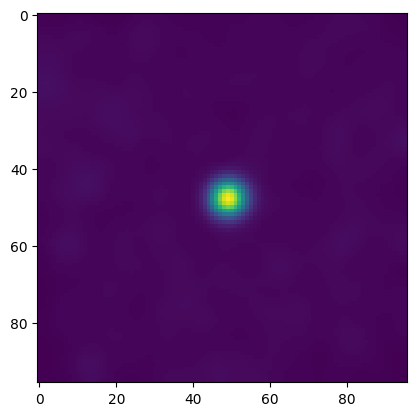

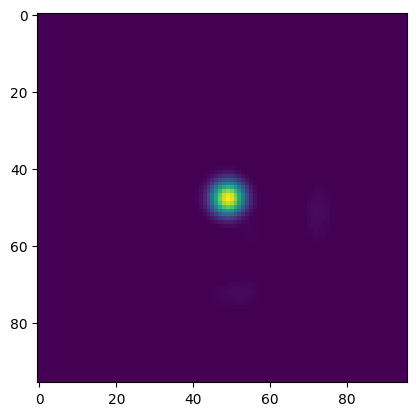

In [24]:
grid_size = 96
edge_size = 6
front = int(edge_size)
back  = int(grid_size-edge_size)

random_image, edges = demeter.make_field_image(random_field_gno, gnomonic_width, pmfield_size, grid_size)
field_image, edges = demeter.make_field_image(full_field_gno, gnomonic_width, pmfield_size, grid_size)

smooth_field = scipy.ndimage.gaussian_filter(field_image,3.0)

plt.imshow(smooth_field.sum(axis=(2,3))/np.max(smooth_field.sum(axis=(2,3))))
plt.clim([0,1])
plt.show()

wv = demeter.WaveNet(grid_size, grid_size, J=4, wavelets = ['bior5.5']).to(device)
out = wv(torch.Tensor(field_image).to(device)).to('cpu').numpy()
rand_out = wv(torch.Tensor(random_image).to(device)).to('cpu').numpy()

#apply smoothing 
out = scipy.ndimage.gaussian_filter(out,3.0)
rand_out = scipy.ndimage.gaussian_filter(rand_out,3.0)

#remove outer edges of image 
out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
out1[front:back,front:back,front:back,front:back] = 1
out1 = out*out1

#standardize the real output 
out = (out-np.mean(rand_out))/np.std(rand_out)

#apply threshold 
edge_size = 6
front = int(edge_size)
back = int(grid_size-edge_size)
nstars = len(data)

#apply significance correction 
out = out / (-0.6*np.log10(nstars)+4.)

#applying thresholding 
mask = out < 5.0 
out[mask] = 0

#remove outer edges of image
out1 = np.zeros((grid_size, grid_size, grid_size, grid_size))
out1[front:back,front:back,front:back,front:back] = 1
out1 = out*out1

plt.imshow(out1.sum(axis=(2,3)))
plt.show()

#find remaining hotspots 
blobs, significance = demeter.find_blobs(out1, threshold=9)


In [25]:
#find clusters in original dataset 
clusters_demeter = demeter.find_clusters(full_df, x_dwarf, y_dwarf, gnomonic_width, pmfield_size, grid_size, blobs)

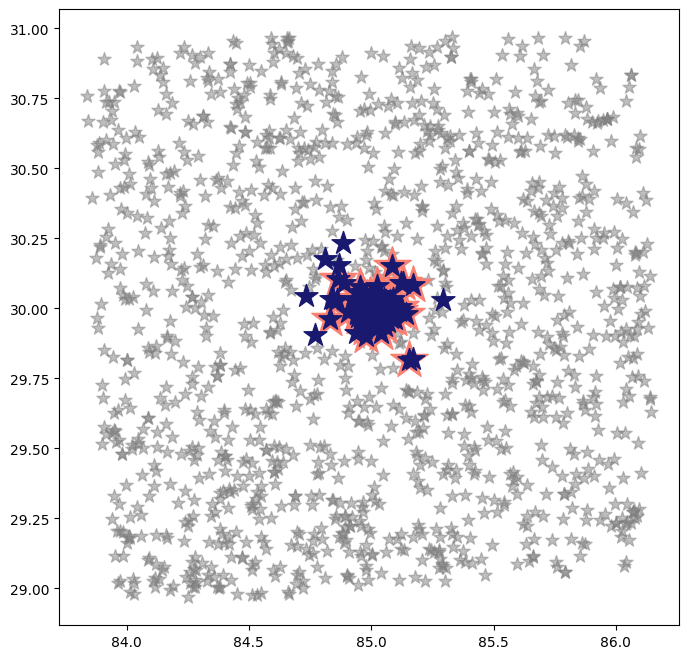

In [27]:
fig, ax = plt.subplots(figsize=(8,8))

#plot background stars 
plt.scatter(full_df['ra'],full_df['dec'], alpha=0.5, color='grey', s=100, marker='*')

#plot injected stars 
plt.scatter(dw_data[:,0], dw_data[:,1], alpha=1., color='salmon',s=800, marker='*')

#plot returned stars
for cluster in clusters_demeter:
    if(len(cluster)>=5):
        plt.scatter(cluster['ra'], cluster['dec'], color='midnightblue',s=300, marker='*')

plt.show()


# EagleEye

In [28]:
K_M = int(0.15 * len(full))
aux_full = np.copy(full)
aux_full = (aux_full - np.min(full, axis = 0)) / (np.max(full, axis = 0) - np.min(full, axis = 0)) 

In [31]:
result_dict_list = []
EE_book_list = []
clusters_list = []

for ref in tqdm(references):
    p = len(full)/(len(full)+len(ref))
    p_ext = 1e-5

    aux_ref = np.copy(ref)
    aux_ref = (aux_ref - np.min(full, axis = 0)) / (np.max(full, axis = 0) - np.min(full, axis = 0)) 
    
    stats_null = compute_the_null(p=p, K_M=K_M)

    result_dictionary, stats_null = EagleEye.Soar(aux_ref, aux_full, K_M=K_M, p_ext=p_ext, n_jobs=10, 
                                          stats_null=stats_null, result_dict_in={})
    clusters = partitioning_function(aux_ref, aux_full, result_dictionary, p_ext=p_ext, Z=2.65)
    EE_book = EagleEye.Repechage(aux_ref, aux_full, result_dictionary, clusters, p_ext=p_ext)

    result_dict_list.append(result_dictionary)
    EE_book_list.append(EE_book)
    clusters_list.append(clusters)
    

  0%|                                                                                                                                                                   | 0/8 [00:00<?, ?it/s]

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


/home/mdelosrios/miniconda3/envs/dwarf/lib/python3.13/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


<IPython.core.display.Math object>

alpha = 1


'DONE!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

 12%|███████████████████▍                                                                                                                                       | 1/8 [00:30<03:30, 30.03s/it]

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

 25%|██████████████████████████████████████▊                                                                                                                    | 2/8 [01:00<03:01, 30.22s/it]

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


/home/mdelosrios/miniconda3/envs/dwarf/lib/python3.13/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


<IPython.core.display.Math object>

alpha = 1


'DONE!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

 38%|██████████████████████████████████████████████████████████▏                                                                                                | 3/8 [01:34<02:38, 31.79s/it]

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


/home/mdelosrios/miniconda3/envs/dwarf/lib/python3.13/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/home/mdelosrios/miniconda3/envs/dwarf/lib/python3.13/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]


<IPython.core.display.Math object>

alpha = 1


'DONE!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 4/8 [02:03<02:04, 31.06s/it]

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

 62%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 5/8 [02:34<01:32, 30.71s/it]

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


/home/mdelosrios/miniconda3/envs/dwarf/lib/python3.13/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/home/mdelosrios/miniconda3/envs/dwarf/lib/python3.13/site-packages/dadapy/id_estimation.py:176: RuntimeWarning: divide by zero encountered in divide
  mus = self.distances[:, 2] / self.distances[:, 1]


<IPython.core.display.Math object>

alpha = 1


'DONE!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 6/8 [02:59<00:57, 28.82s/it]

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


/home/mdelosrios/miniconda3/envs/dwarf/lib/python3.13/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(
/home/mdelosrios/miniconda3/envs/dwarf/lib/python3.13/site-packages/dadapy/_utils/utils.py:152: UserWarning: There are points with neighbours at 0 distance, meaning the dataset probably has identical points.
This can cause problems in various routines.
We suggest to either perform smearing of distances using
remove_zero_dists()
or remove identical points using
remove_identical_points()).
  warnings.warn(


<IPython.core.display.Math object>

alpha = 1


'DONE!'

<IPython.core.display.Math object>

alpha = 1
alpha = 2


'DONE!'

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 7/8 [03:30<00:29, 29.47s/it]

-----------------------------------------------------------------
Eagle...Soar!
-----------------------------------------------------------------
Compute the nearest neighbours
KNN completed: 0.00 %
-----------------------------------------------------------------
Flagging of putative anomalous points
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Pruning via iterative density equalization (IDE)
-----------------------------------------------------------------


<IPython.core.display.Math object>

'DONE!'

<IPython.core.display.Math object>

'DONE!'

-----------------------------------------------------------------
Clustering
-----------------------------------------------------------------
-----------------------------------------------------------------
Repêchage
-----------------------------------------------------------------


<IPython.core.display.Math object>

alpha = 1


'DONE!'

<IPython.core.display.Math object>

alpha = 1


'DONE!'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:59<00:00, 29.89s/it]


In [32]:
from collections import Counter

# Let's count how many time a star appear as anomalous
cluster_indices_list = []
aux_list = []
for iref in range(len(references)):
    try:
        cls = EE_book_list[iref]['Y_OVER_clusters'] #[0]['Repechaged']
    except:
        cls = []
    if len(cls) > 0:
        for icl, cl in enumerate(cls):
            cluster_indices_list.append( cls[cl]['Repechaged'] )

aux = [elem for lista in cluster_indices_list for elem in lista]
index_count = Counter(aux)

freq = np.zeros(len(full))
for i in range(len(full)):
    try:
        freq[i] = index_count[i]
    except:
        pass

Rep
✅ Plot guardado en ../graphs/EE_result_137_ref_0.pdf


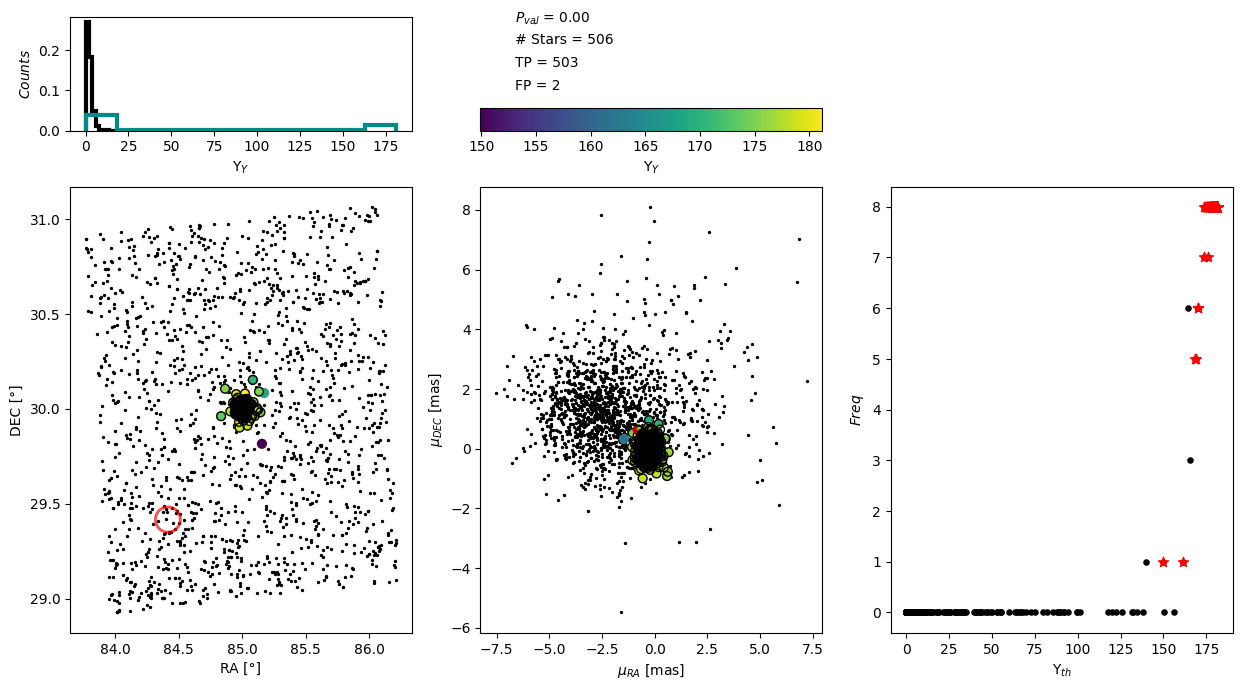

Rep
✅ Plot guardado en ../graphs/EE_result_137_ref_1.pdf


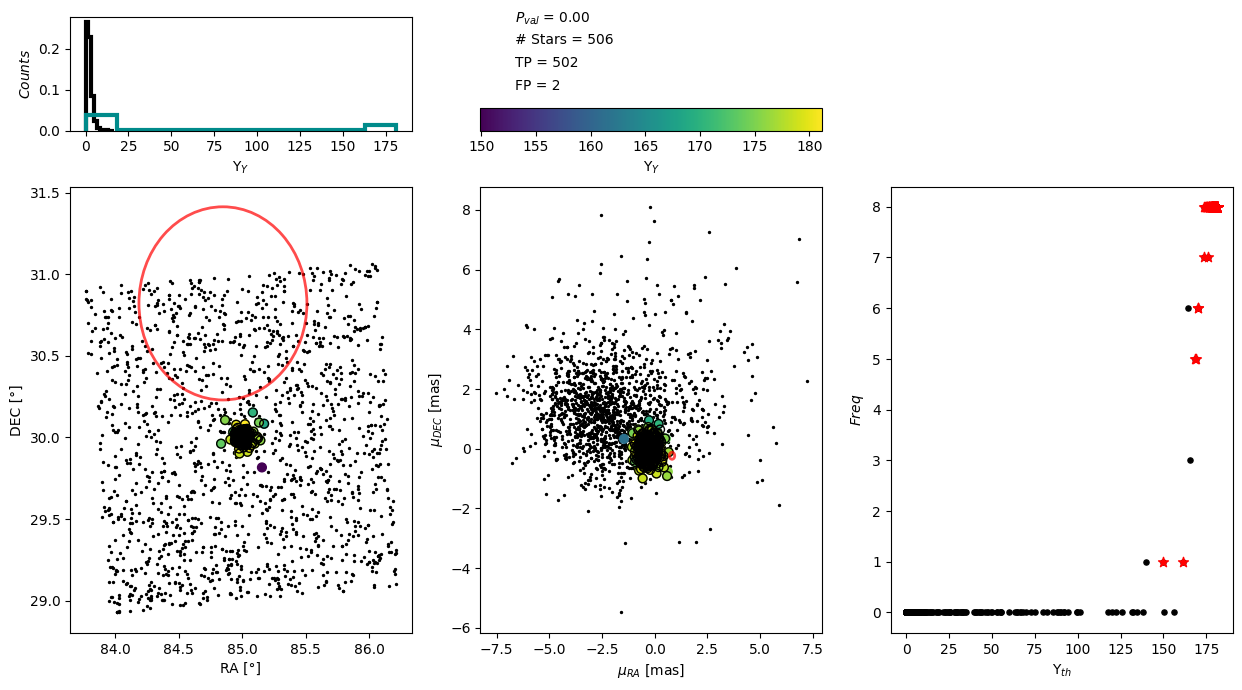

Rep
✅ Plot guardado en ../graphs/EE_result_137_ref_2.pdf


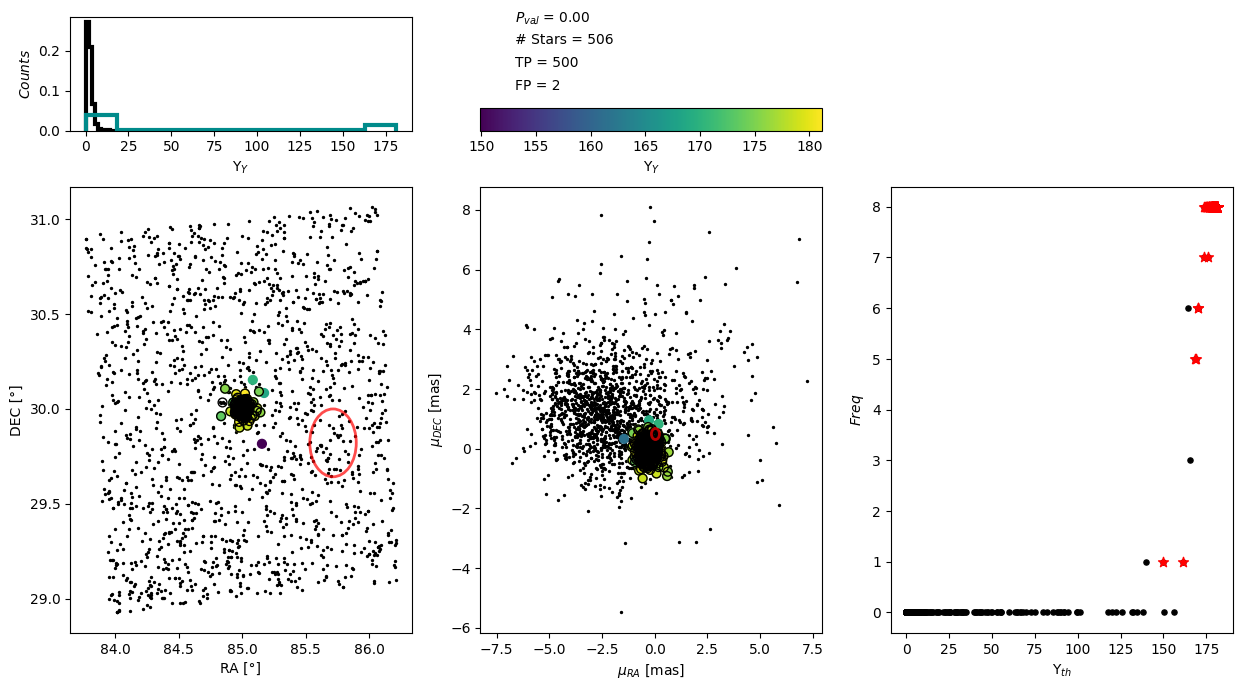

Rep
✅ Plot guardado en ../graphs/EE_result_137_ref_3.pdf


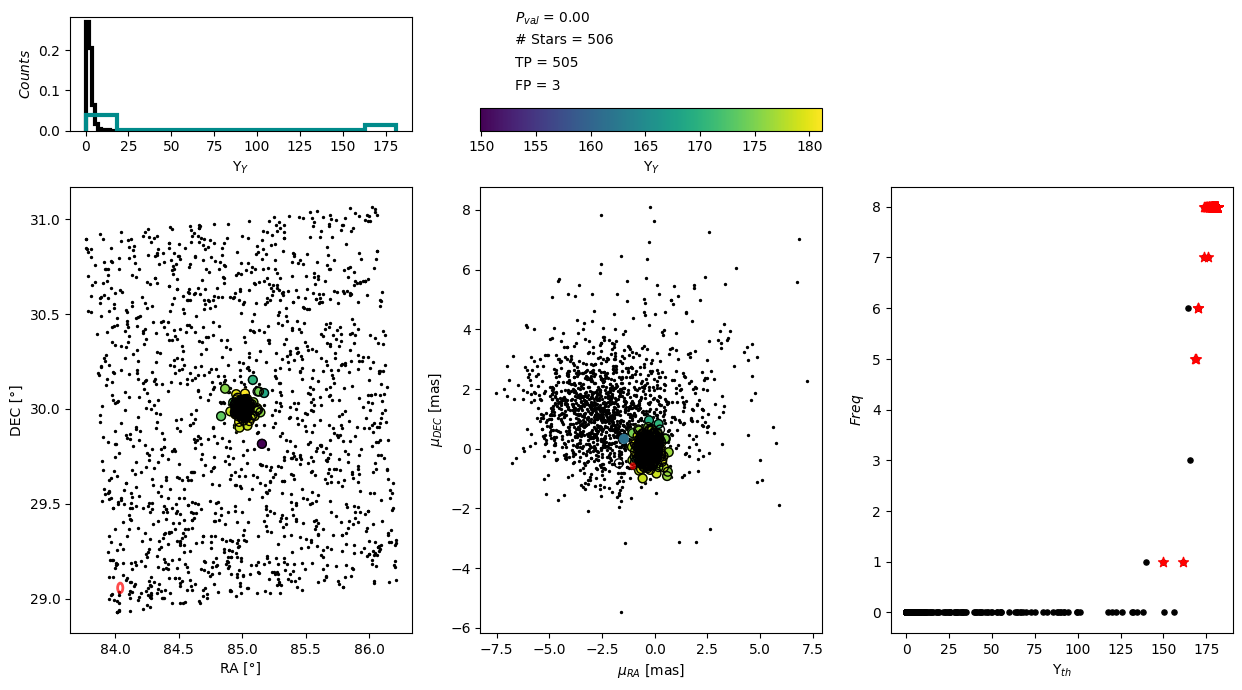

Rep
✅ Plot guardado en ../graphs/EE_result_137_ref_4.pdf


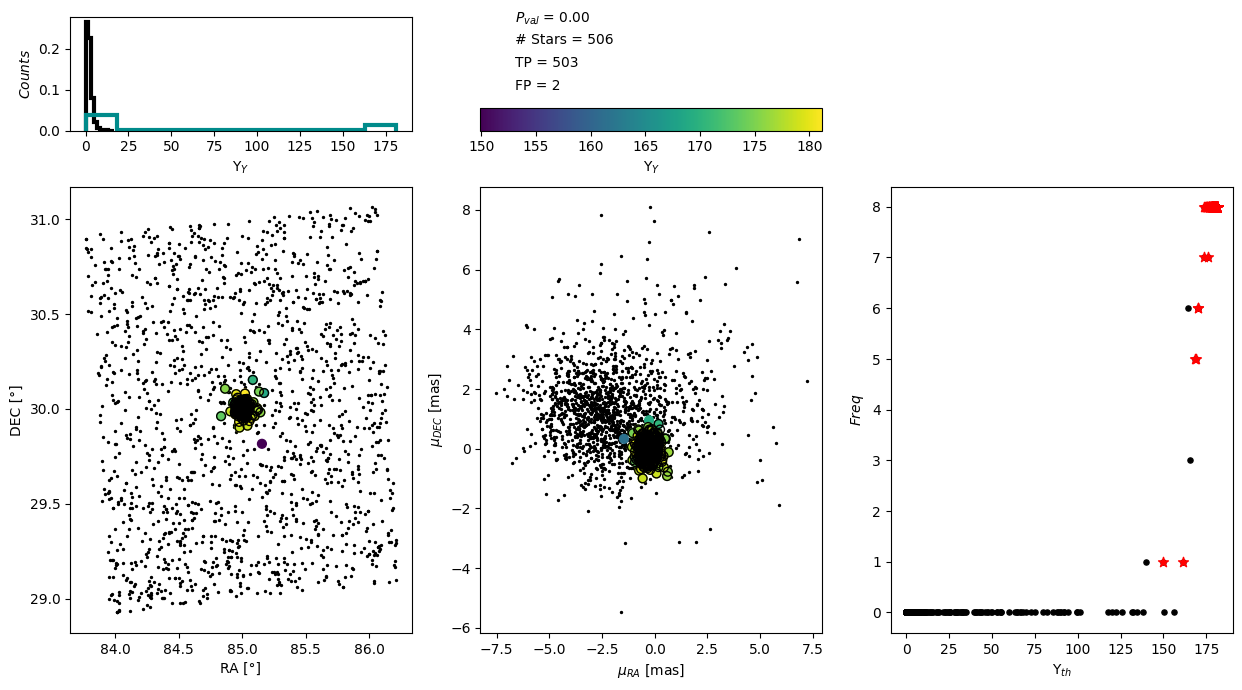

Rep
✅ Plot guardado en ../graphs/EE_result_137_ref_5.pdf


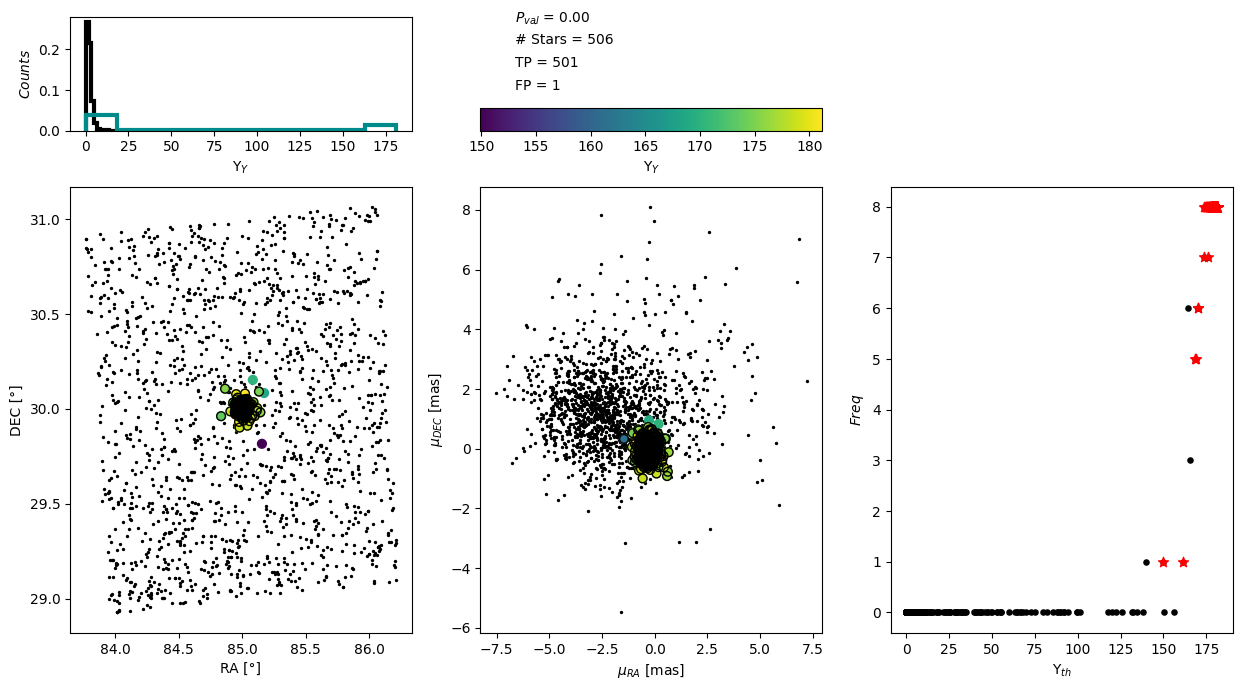

Rep
✅ Plot guardado en ../graphs/EE_result_137_ref_6.pdf


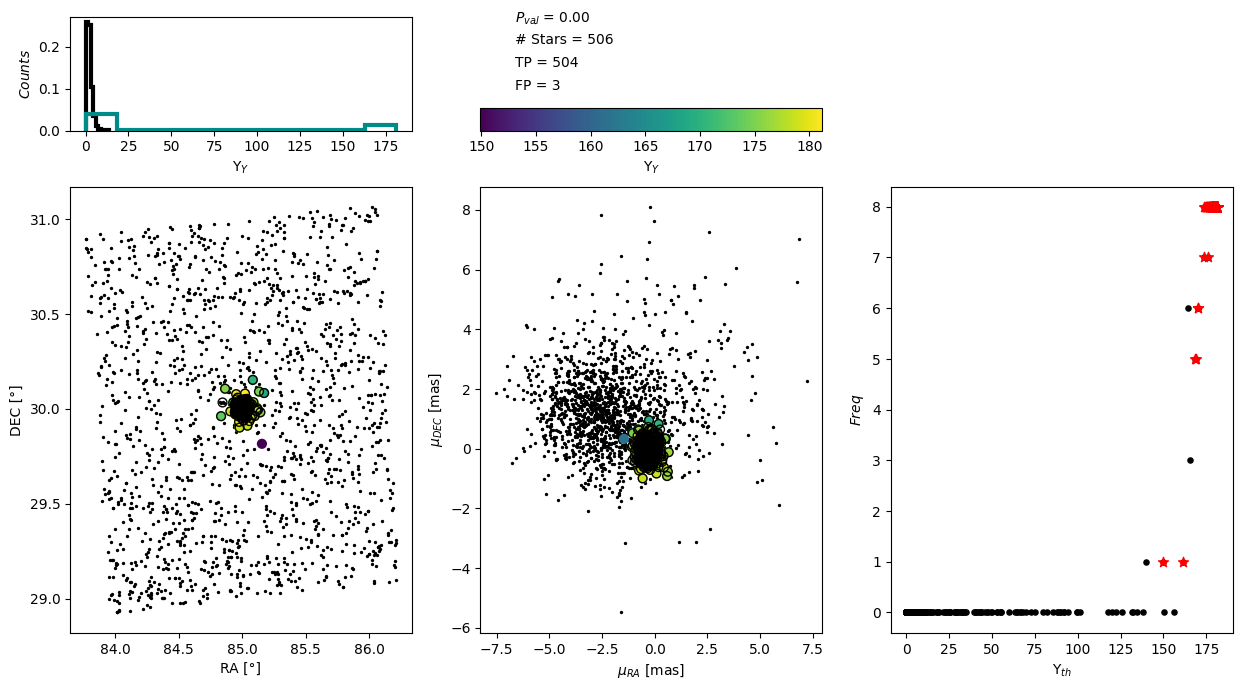

Rep
✅ Plot guardado en ../graphs/EE_result_137_ref_7.pdf


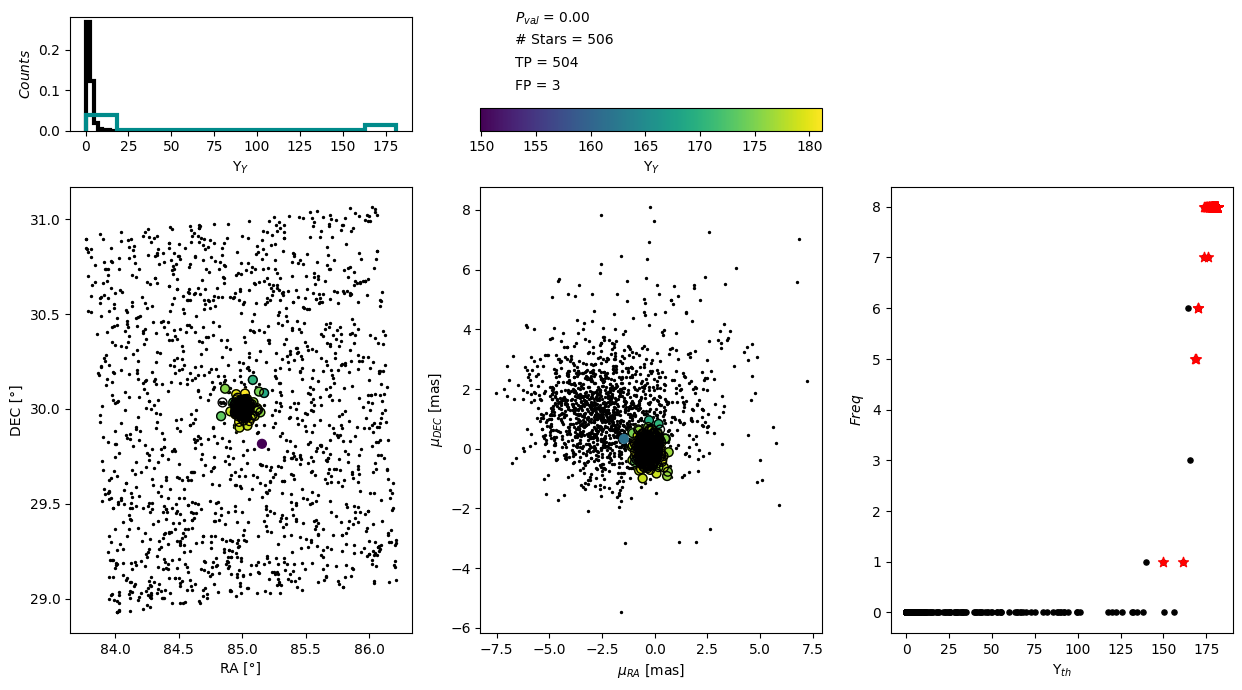

In [74]:
for iref in range(len(references)):
    # Let's pick a reference
    #iref = 0
    upsilon = result_dict_list[iref]['Upsilon_i_Y']
    upsilon_x = result_dict_list[iref]['Upsilon_i_X']
    
    # Let's compute the mean upsilon
    upsilon_list = []
    upsilonNull_list = []
    for i in range(len(result_dict_list)):
        upsilon = result_dict_list[i]['Upsilon_i_Y']
        upsilon_list.append(upsilon)
        upsilonNull_list.append(result_dict_list[i]['stats_null'][list(result_dict_list[i]['stats_null'].keys())[0]])
    upsilon = np.mean(np.asarray(upsilon_list),axis = 0)
    
    # The upsilon threshold for considering a star as anomalous will be the max all the nulls
    up_th = np.max(np.asarray(upsilonNull_list)) #np.quantile(upsilon, 0.99)
    
    
    fig,ax = plt.subplots(2,3, gridspec_kw = {'width_ratios':[1,1,1], 'height_ratios':[0.51,2]},
                         #sharex = 'col', sharey = 'row',
                          figsize = (15,8))
    
    try:
        overdensity_ind = np.asarray(EE_book_list[iref]['Y_OVER_clusters'][0]['Repechaged'])
        if len(overdensity_ind) == 0:
            overdensity_ind = np.asarray(np.where(upsilon >= up_th)[0])
            #ax[1,0].axvline(x = np.quantile(upsilon, 0.8))
            ax[1,2].axvline(x = up_th)
            print('Th')
        else:
            print('Rep')
    except:        
        overdensity_ind = np.asarray(np.where(upsilon >= up_th)[0])
        #ax[1,0].axvline(x = np.quantile(upsilon, 0.8))
        ax[1,2].axvline(x = up_th)
        print('Th')
        
    bkg_ind = np.delete(np.arange(len(upsilon)), overdensity_ind)
    
    TP = len(np.where(overdensity_ind >= (len(full) - len(dw_data)))[0]) # True positives
    FP = len(np.where(overdensity_ind < (len(full) - len(dw_data)))[0]) # False positives
    TN = len(np.where(bkg_ind < (len(full) - len(dw_data)))[0]) # True negative
    FN = len(np.where(bkg_ind >= (len(full) - len(dw_data)))[0]) # False negative
    
    # Let's plot upsilon histograms
    statistic, p_value = ks_2samp(upsilon, np.random.choice(result_dict_list[iref]['stats_null'][list(result_dict_list[iref]['stats_null'].keys())[0]], size = len(upsilon)))
    ax[0,0].hist(result_dict_list[iref]['stats_null'][list(result_dict_list[iref]['stats_null'].keys())[0]], 
                 histtype = 'step', density = True, color = 'black', lw = 3)
    ax[0,0].hist(upsilon, histtype = 'step', density = True, color = 'darkcyan', lw = 3)
    ax[0,1].text(0.1,0.96,'$P_{val}̣$ = ' + '{:.2f}'.format(p_value), transform = ax[0,1].transAxes)
    ax[0,1].text(0.1,0.76,'# Stars = {}'.format(len(dw_data)), transform = ax[0,1].transAxes)
    ax[0,1].text(0.1,0.56,'TP = {}'.format(TP), transform = ax[0,1].transAxes)
    ax[0,1].text(0.1,0.36,'FP = {}'.format(FP), transform = ax[0,1].transAxes)
    ax[0,1].set_axis_off()
    
    # Let's plot an scatter of all the stars
    ax[1,0].scatter(full[:,0], full[:,1], c = 'black', s = 2)
    img = ax[1,0].scatter(dw_data[:,0], dw_data[:,1], c = upsilon[-len(dw_data):], s = 40)
    ax[1,0].scatter(full[overdensity_ind,0], full[overdensity_ind,1], edgecolors = 'black', s = 40, marker = 'o', facecolors='none')
    #sns.kdeplot(x=full[-len(dw_data):,0], y=full[-len(dw_data):,1], color = 'magenta', fill=False, ax = ax[1,0], levels = [0.5, 0.9], alpha = [0.3, 0.9])
    #ax[1,0].set_xlim(dw_data[:,0].min(), dw_data[:,0].max())
    #ax[1,0].set_ylim(dw_data[:,1].min(), dw_data[:,1].max())
    
    ax[1,1].scatter(full[:,2], full[:,3], c = 'black', s = 2)
    ax[1,1].scatter(dw_data[:,2], dw_data[:,3], c = upsilon[-len(dw_data):], s = 40)
    ax[1,1].scatter(full[overdensity_ind,2], full[overdensity_ind,3], edgecolors = 'black', s = 40, marker = 'o', facecolors='none')
    #ax[1,1].set_xlim(dw_data[:,2].min(), dw_data[:,2].max())
    #ax[1,1].set_ylim(dw_data[:,3].min(), dw_data[:,3].max())
    
    aux_freq = freq
    ax[1,2].scatter(upsilon, aux_freq, c = 'black', s = 55, marker = '.',zorder=0)
    ax[1,2].scatter(upsilon[-len(dw_data):], aux_freq[-len(dw_data):], color = 'red', s = 55, marker = '*', zorder = 2)
    #ax[1,2].scatter(upsilon[aux_ind], aux_freq[aux_ind], color = 'red', s = 85, marker = '*', zorder = 1)
    
    ax[0,0].set_xlabel('$\\Upsilon_{Y}$')
    ax[0,0].set_ylabel('$Counts$')
    
    ax[1,0].set_xlabel('RA [°]')
    ax[1,0].set_ylabel('DEC [°]')
    
    ax[1,1].set_xlabel('$\\mu_{RA }$ [mas]')
    ax[1,1].set_ylabel('$\\mu_{DEC}$ [mas]')
    
    ax[1,2].set_xlabel('$\\Upsilon_{Y}$')
    ax[1,2].set_ylabel('$Freq$')
    
    ax[0,2].set_axis_off()
    
    ax[1,2].set_xlabel('$\\Upsilon_{th}$')
    
    cax = inset_axes(ax[0,1],
                     width="100%",
                     height="20%",
                     loc='lower left',
                     borderpad=0)
    
    cbar = plt.colorbar(img, cax=cax, orientation = 'horizontal')
    cbar.set_label('$\\Upsilon_{Y}$')
    
    if iref in [0,1,2,3]:
        elipse = patches.Ellipse((l_dwarf_in_ref[iref], b_dwarf_in_ref[iref]), 
                                 size_l_dwarf_in_ref[iref], size_b_dwarf_in_ref[iref], 
                                edgecolor='red', facecolor='none', 
                                alpha=0.7, linewidth=2)
        ax[1,0].add_patch(elipse)
        
        elipse = patches.Ellipse((mul_dwarf_in_ref[iref], mub_dwarf_in_ref[iref]), 
                                 size_mul_dwarf_in_ref[iref], size_mub_dwarf_in_ref[iref], 
                                edgecolor='red', facecolor='none', 
                                alpha=0.7, linewidth=2)
        ax[1,1].add_patch(elipse)
    
    auto_save_plot(f'EE_result_{ind_good}_ref_{iref}.pdf')